# Step [1]: Prepare Libraries and Data
### [1.1] Include All Required Libraries

In [1]:
import nltk
import os
import re
import heapq  
import pickle
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.summarization import summarize
from nltk.cluster.util import cosine_distance
from string import punctuation
from nltk.corpus import stopwords
punctuation = punctuation + '\n'
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from tensorflow import keras
from sklearn.metrics import confusion_matrix
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### [1.2] Defining Text Categories

In [2]:
categories = ['Business', 'Entertainment', 'Politics', 'Sport', 'Technology']

### [1.3] Unzipping The Dataset Zip File


In [3]:
!unzip bbc.zip

Archive:  bbc.zip
   creating: bbc/
   creating: bbc/entertainment/
  inflating: bbc/entertainment/289.txt  
  inflating: bbc/entertainment/262.txt  
  inflating: bbc/entertainment/276.txt  
  inflating: bbc/entertainment/060.txt  
  inflating: bbc/entertainment/074.txt  
  inflating: bbc/entertainment/048.txt  
  inflating: bbc/entertainment/114.txt  
  inflating: bbc/entertainment/100.txt  
  inflating: bbc/entertainment/128.txt  
  inflating: bbc/entertainment/316.txt  
  inflating: bbc/entertainment/302.txt  
  inflating: bbc/entertainment/303.txt  
  inflating: bbc/entertainment/317.txt  
  inflating: bbc/entertainment/129.txt  
  inflating: bbc/entertainment/101.txt  
  inflating: bbc/entertainment/115.txt  
  inflating: bbc/entertainment/049.txt  
  inflating: bbc/entertainment/075.txt  
  inflating: bbc/entertainment/061.txt  
  inflating: bbc/entertainment/277.txt  
  inflating: bbc/entertainment/263.txt  
  inflating: bbc/entertainment/288.txt  
  inflating: bbc/entertainment

### [1.4] Reading The Dataset Into Dataframe


In [4]:
directory = 'bbc'

data = pd.DataFrame(columns = ["Text","Category"])

for root, subdirectories, files in os.walk(directory):
    for subdirectory in subdirectories:
        for filename in os.listdir(directory+'/'+subdirectory):
            if filename.endswith(".txt"):
                file = open(directory+'/'+subdirectory+'/'+filename, "r", encoding = 'unicode_escape')
                data.loc[data.shape[0]] = [file.read(),subdirectory]

data

,Text,Category
0,Monsanto fined $1.5m for bribery\n\nThe US agr...,business
1,"GM, Ford cut output as sales fall\n\nUS car fi...",business
2,Wal-Mart fights back at accusers\n\nTwo big US...,business
3,Rank 'set to sell off film unit'\n\nLeisure gr...,business
4,Georgia plans hidden asset pardon\n\nGeorgia i...,business
...,...,...
2219,Bond game fails to shake or stir\n\nFor gaming...,tech
2220,Europe backs digital TV lifestyle\n\nHow peopl...,tech
2221,The future in your pocket\n\nIf you are a geek...,tech
2222,California sets fines for spyware\n\nThe maker...,tech


###[1.5] Visualization of Data

In [5]:
data['Category'].value_counts()

business         510
sport            510
politics         417
tech             401
entertainment    386
Name: Category, dtype: int64

Text(0, 0.5, 'Number of Articles')

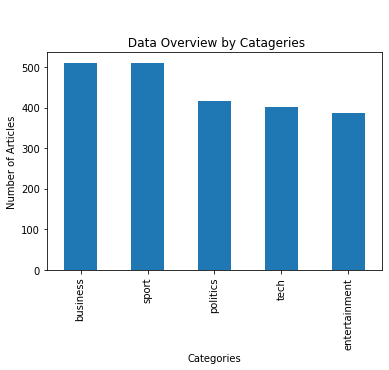

In [6]:
data['Category'].value_counts().plot.bar(ylim=0)
plt.title("\n\n Data Overview by Catageries")
plt.xlabel("Categories")
plt.ylabel("Number of Articles")

# Step [2]: Data Preprocessing
### [2.1] Delete links

In [7]:
def delete_links(input_text):
    pattern  = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    out_text = re.sub(pattern, ' ', input_text)
    return out_text

### [2.2] Fixing word lengthening

In [8]:
def delete_repeated_characters(input_text):
    pattern  = r'(.)\1{2,}'
    out_text = re.sub(pattern, r"\1\1", input_text)
    return out_text

### [2.3] Delete bad symbols

In [9]:
def clean_text(input_text):
    replace = r'[/(){}\[\]|@âÂ,;\?\'\"\*…؟–’،!&\+-:؛-]'
    out_text = re.sub(replace, " ", input_text)
    words = nltk.word_tokenize(out_text)
    words = [word for word in words if word.isalpha()]
    out_text = ' '.join(words)
    return out_text

### [2.4] Delete stopwords

In [10]:
def delete_stopwords(input_text):
    stop_words = set(nltk.corpus.stopwords.words("english"))
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    wnl = nltk.WordNetLemmatizer()
    lemmatizedTokens =[wnl.lemmatize(t) for t in tokens]
    out_text = [w for w in lemmatizedTokens if not w in stop_words]
    out_text = ' '.join(out_text)
    return out_text

### [2.5] Data Preparation

In [11]:
def text_prepare(input_text):
    out_text = delete_links(input_text)
    out_text = delete_repeated_characters(out_text)
    out_text = clean_text(out_text)
    out_text = delete_stopwords(out_text)
    out_text = out_text.lower()
    return out_text

### [2.6] Data After Preprocessing

In [12]:
data['Processed Text'] = data['Text'].apply(text_prepare)
data

,Text,Category,Processed Text
0,Monsanto fined $1.5m for bribery\n\nThe US agr...,business,monsanto fined bribery the us agrochemical gia...
1,"GM, Ford cut output as sales fall\n\nUS car fi...",business,gm ford cut output sale fall us car firm gener...
2,Wal-Mart fights back at accusers\n\nTwo big US...,business,wal mart fight back accuser two big us name la...
3,Rank 'set to sell off film unit'\n\nLeisure gr...,business,rank set sell film unit leisure group rank cou...
4,Georgia plans hidden asset pardon\n\nGeorgia i...,business,georgia plan hidden asset pardon georgia offer...
...,...,...,...
2219,Bond game fails to shake or stir\n\nFor gaming...,tech,bond game fails shake stir for gaming fan word...
2220,Europe backs digital TV lifestyle\n\nHow peopl...,tech,europe back digital tv lifestyle how people re...
2221,The future in your pocket\n\nIf you are a geek...,tech,the future pocket if geek gadget fan next mont...
2222,California sets fines for spyware\n\nThe maker...,tech,california set fine spyware the maker computer...


# Step [3]: Data Splitting and Vectorizing
### [3.1] Label encoding

In [13]:
label_encoder = LabelEncoder()
data['Category Encoded'] = label_encoder.fit_transform(data['Category'])
data

,Text,Category,Processed Text,Category Encoded
0,Monsanto fined $1.5m for bribery\n\nThe US agr...,business,monsanto fined bribery the us agrochemical gia...,0
1,"GM, Ford cut output as sales fall\n\nUS car fi...",business,gm ford cut output sale fall us car firm gener...,0
2,Wal-Mart fights back at accusers\n\nTwo big US...,business,wal mart fight back accuser two big us name la...,0
3,Rank 'set to sell off film unit'\n\nLeisure gr...,business,rank set sell film unit leisure group rank cou...,0
4,Georgia plans hidden asset pardon\n\nGeorgia i...,business,georgia plan hidden asset pardon georgia offer...,0
...,...,...,...,...
2219,Bond game fails to shake or stir\n\nFor gaming...,tech,bond game fails shake stir for gaming fan word...,4
2220,Europe backs digital TV lifestyle\n\nHow peopl...,tech,europe back digital tv lifestyle how people re...,4
2221,The future in your pocket\n\nIf you are a geek...,tech,the future pocket if geek gadget fan next mont...,4
2222,California sets fines for spyware\n\nThe maker...,tech,california set fine spyware the maker computer...,4


### [3.2] Saving the Final Dataframe to CSV File

In [14]:
data.to_csv('bbc_processed.csv')

### [3.3] Splitting the data to train and text

In [15]:
train_text, test_text, train_cat, test_cat = train_test_split(data['Processed Text'], data['Category Encoded'], test_size=0.2, random_state=0)

print ("Train size: %d" % len(train_text))
print ("Test size: %d" % len(test_text))

Train size: 1779
Test size: 445


### [3.4] TF-IDF vectorizer

In [16]:
def tfidf_features(X_train, X_test, ngram_range):
    tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, ngram_range))
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train, X_test

In [17]:
features_train, features_test = tfidf_features(train_text, test_text, 2)

# [4] Classifier Models
### [4.1] Fitting Imported Models

In [18]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [19]:
def fit_model(model_name):
    if model_name == 'ridge_model':
        model_name = RidgeClassifier()
    elif model_name == 'random_forest_model':
        model_name = RandomForestClassifier()
    elif model_name == 'logistic_regression_model':
        model_name = LogisticRegression()
    elif model_name == 'kneighbors_model':
        model_name = KNeighborsClassifier()
    elif model_name == 'decision_tree_model':
        model_name = DecisionTreeClassifier()
    elif model_name == 'gaussian_nb_model':
        model_name = GaussianNB()
    model_name.fit(features_train.toarray(), train_cat)
    model_predictions = model_name.predict(features_test.toarray())
    cnf_matrix = confusion_matrix(test_cat, model_predictions)
    plt.figure(figsize=(12,10))
    plot_confusion_matrix(cnf_matrix, classes=categories)
    plt.show()
    print("Accuracy on test: ", accuracy_score(test_cat, model_predictions))
    return model_name

### [4.2] Fitting Keras Tokenizer

In [20]:
max_words = 100000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_text)
def fit_keras_tokenizer():
  # fit tokenizer to our training text data
  x_train = tokenize.texts_to_matrix(train_text)
  x_test = tokenize.texts_to_matrix(test_text)
  # Use sklearn utility to convert label strings to numbered index
  encoder = LabelEncoder()
  encoder.fit(train_cat)
  y_train = encoder.transform(train_cat)
  y_test = encoder.transform(test_cat)
  # Converts the labels to a one-hot representation
  num_classes = np.max(y_train) + 1
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  batch_size = 32
  epochs = 2
  drop_ratio = 0.5
  # Build the model
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(512, input_shape=(max_words,)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dense(num_classes))
  model.add(keras.layers.Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
  # Evaluate the accuracy of our trained model
  score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
  print('Accuracy on test:', score[1])
  return model

#[5] Running Classifiers and Saving Pickle Files

#### [5.1] Ridge classifier

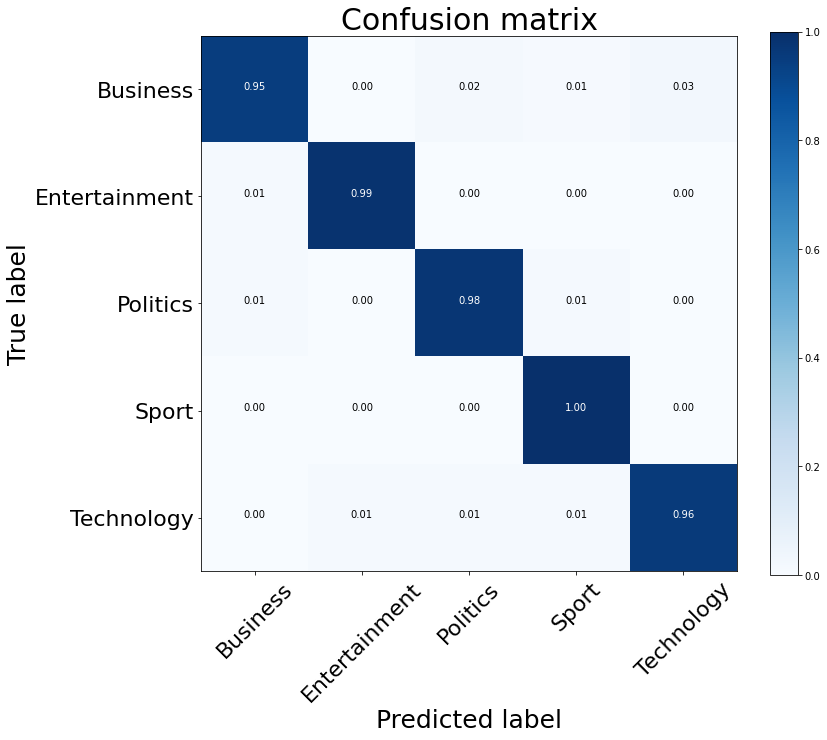

Accuracy on test:  0.9730337078651685


In [21]:
ridge_model = fit_model('ridge_model')
pickle.dump(ridge_model, open('ridge_model.pkl','wb'))

#### [5.2] Random forest classifier

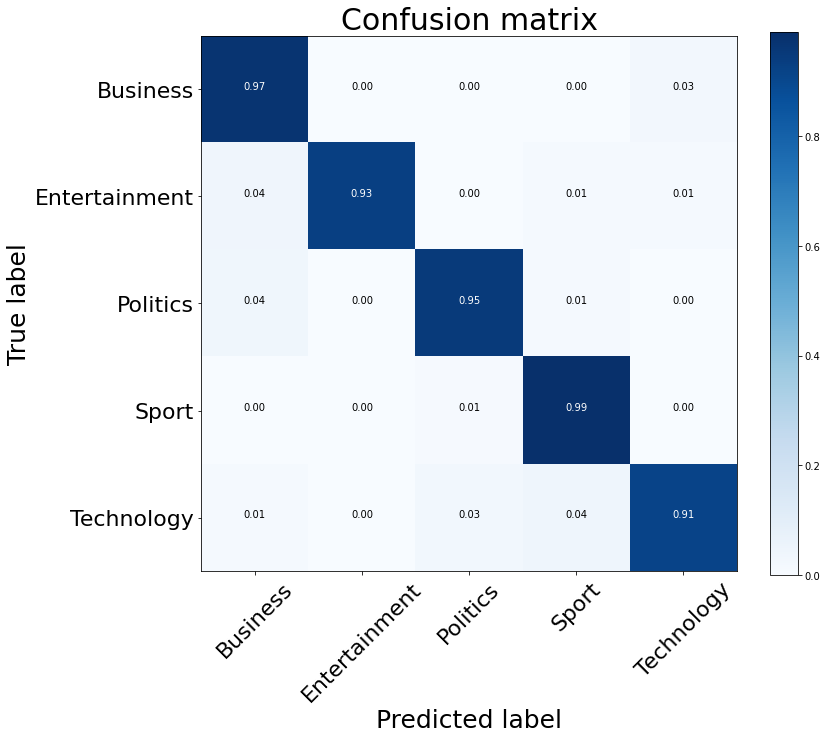

Accuracy on test:  0.9573033707865168


In [22]:
random_forest_model = fit_model('random_forest_model')
pickle.dump(random_forest_model, open('random_forest_model.pkl','wb'))

#### [5.3]  Logistic regression classifier

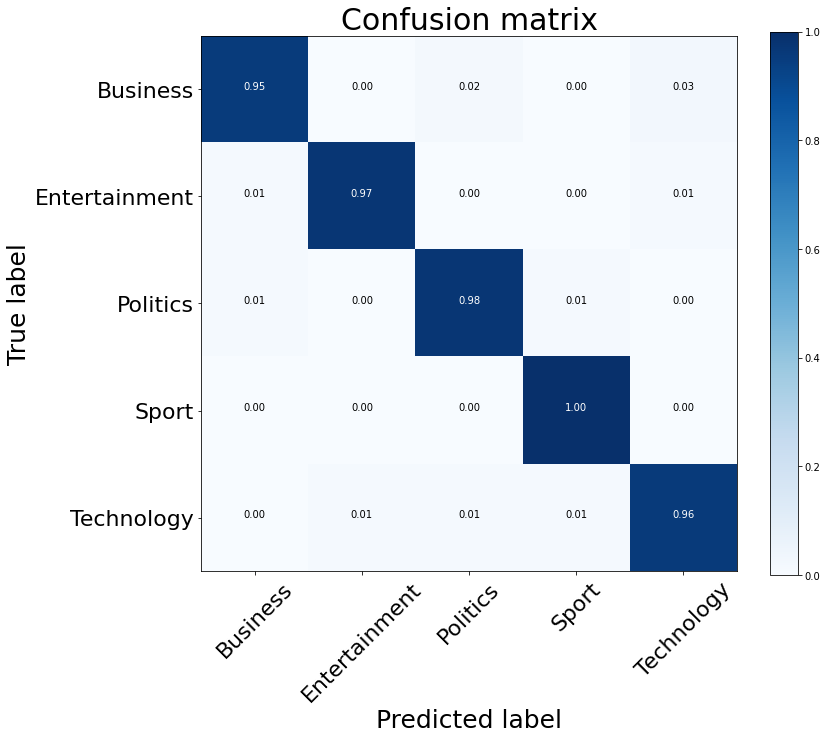

Accuracy on test:  0.9730337078651685


In [23]:
logistic_regression_model = fit_model('logistic_regression_model')
pickle.dump(logistic_regression_model, open('logistic_regression_model.pkl','wb'))

#### [5.4] K-Neighbors classifier

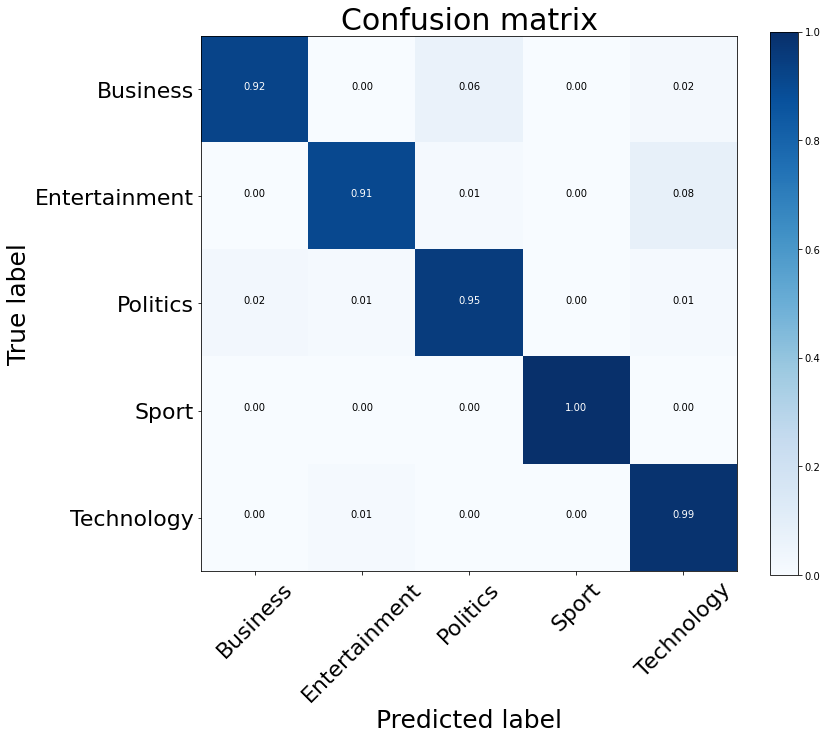

Accuracy on test:  0.952808988764045


In [24]:
kneighbors_model = fit_model('kneighbors_model')
pickle.dump(kneighbors_model, open('kneighbors_model.pkl','wb'))

#### [5.5] Decision tree classifier

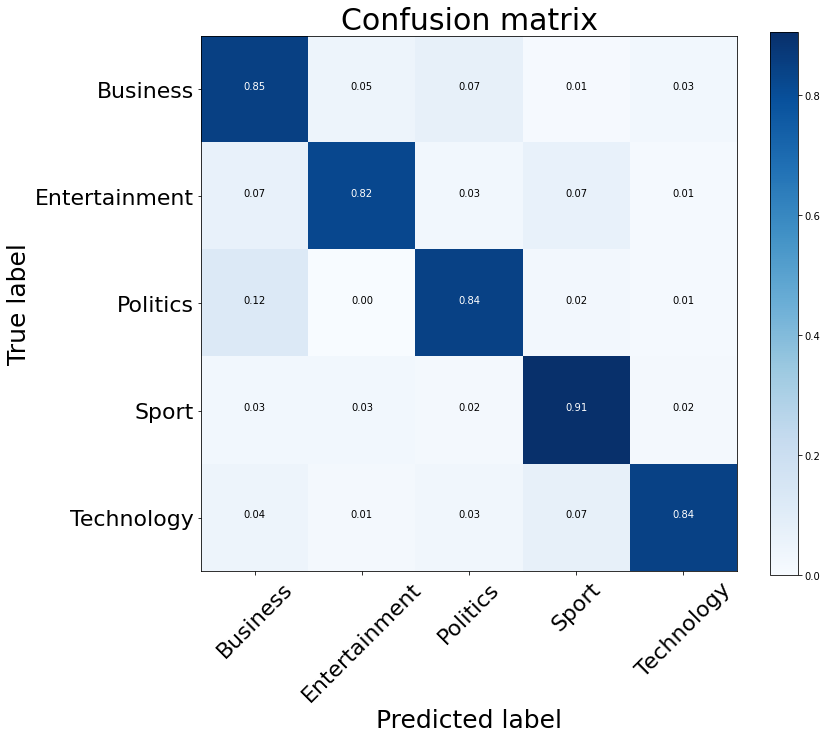

Accuracy on test:  0.8561797752808988


In [25]:
decision_tree_model = fit_model('decision_tree_model')
pickle.dump(decision_tree_model, open('decision_tree_model.pkl','wb'))

#### [5.6] GaussianNB classifier

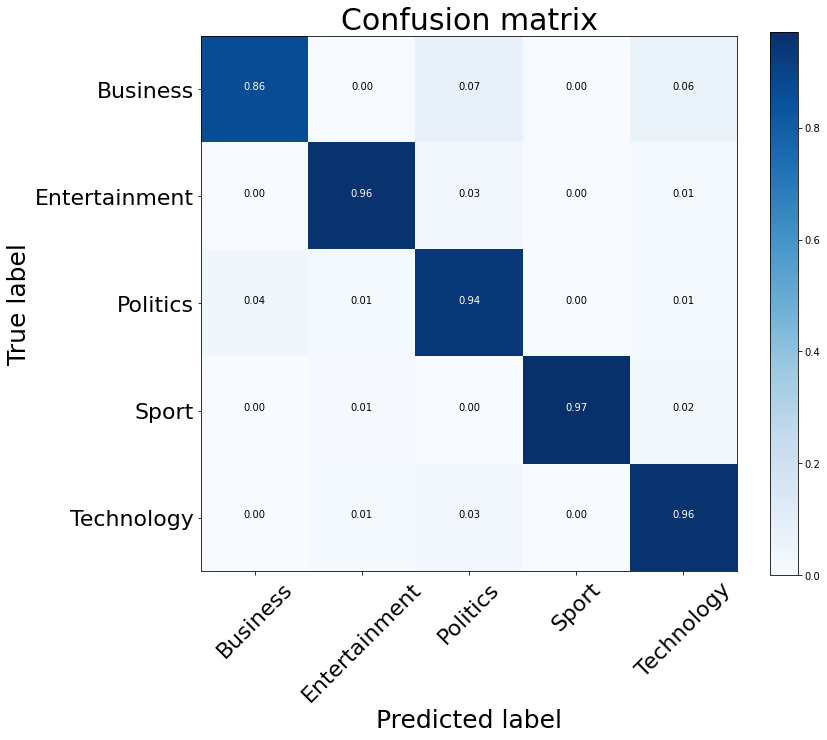

Accuracy on test:  0.9348314606741573


In [26]:
gaussian_nb_model = fit_model('gaussian_nb_model')
pickle.dump(gaussian_nb_model, open('gaussian_nb_model.pkl','wb'))

#### [5.7] Keras Tokenizer Classifier

In [27]:
keras_tokenizer = fit_keras_tokenizer()
pickle.dump(keras_tokenizer, open('keras_tokenizer.pkl','wb'))

Epoch 1/2
51/51 [==============================] - 18s 342ms/step - loss: 0.2713 - accuracy: 0.9269 - val_loss: 0.0574 - val_accuracy: 0.9775
Epoch 2/2
14/14 [==============================] - 2s 115ms/step - loss: 0.0829 - accuracy: 0.9663
Accuracy on test: 0.966292142868042
INFO:tensorflow:Assets written to: ram://93d9ffac-180a-4c89-a859-d5eff852b3a8/assets


# Step [6]: Summarizers

### Step [6.1]: Gensim Summarizer

In [28]:
def gensim_summarizer(article, number_of_sentence):
  r = 1
  extracts=sent_tokenize(article)
  if(number_of_sentence < len(extracts)):
    r = number_of_sentence / len(extracts)
  
  summary = summarize(article, ratio=r, split=False)
  return summary

### Step [6.2]: NLTK Summarizer

In [29]:
def nltk_summarizer(input_text, number_of_sentence):
    stopWords = set(nltk.corpus.stopwords.words("english"))
    word_frequencies = {}  
    for word in nltk.word_tokenize(input_text):  
        if word not in stopWords:
            if word not in punctuation:
                if word not in word_frequencies.keys():
                    word_frequencies[word] = 1
                else:
                    word_frequencies[word] += 1

    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

    sentence_list = nltk.sent_tokenize(input_text)
    sentence_scores = {}  
    for sent in sentence_list:  
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]

    summary_sentences = heapq.nlargest(number_of_sentence, sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)
     
    return summary

### Step [6.3]: Summarization Using Text Rank

In [30]:
def get_sentences(article):
  extracts=sent_tokenize(article)
  sentences=[]
  for extract in extracts:
    clean_sentence=extract.replace("[^a-zA-Z0-9]"," ")   ## Removing special characters
    obtained=word_tokenize(extract) 
    sentences.append(obtained)
  return sentences, extracts


def get_similarity(sent_1,sent_2,stop_words):
  
  sent_1=[w.lower() for w in sent_1]
  sent_2=[w.lower() for w in sent_2]

  total=list(set(sent_1+sent_2)) ## Removing duplicate words in total set

  vec_1= [0] * len(total)
  vec_2= [0] * len(total)


  ## Count Vectorization of two sentences
  for w in sent_1:
    if w not in stop_words:
      vec_1[total.index(w)]+=1

  for w in sent_2:
    if w not in stop_words:
      vec_2[total.index(w)]+=1

  return 1-cosine_distance(vec_1,vec_2)

def build_matrix(sentences):
  stop_words = stopwords.words('english')

  sim_matrix=np.zeros((len(sentences),len(sentences)))
  ## Adjacency matrix

  for id1 in range(len(sentences)):
    for id2 in range(len(sentences)):
      if id1==id2:  #escaping diagonal elements
        continue
      else:
        sim_matrix[id1][id2]=get_similarity(sentences[id1],sentences[id2],stop_words)

  return sim_matrix

def textrank(text, eps=0.000001, d=0.85):
    score_mat = np.ones(len(text)) / len(text)
    delta=1
    while delta>eps:
        score_mat_new = np.ones(len(text)) * (1 - d) / len(text) + d * text.T.dot(score_mat)
        delta = abs(score_mat_new - score_mat).sum()
        score_mat = score_mat_new
    return score_mat_new


def textrank_summarizer(article, number_of_sentence):
  summarized=[]
  clean_sentences, sentences=get_sentences(article)
  sim_matrix=build_matrix(clean_sentences)
  score=textrank(sim_matrix)

  ranked_sentence = sorted(((score[i],s) for i,s in enumerate(sentences)), reverse=True)

  if len(ranked_sentence) < number_of_sentence: number_of_sentence = len(ranked_sentence)
  
  for i in range(number_of_sentence):
      summarized.append(ranked_sentence[i][1])

  return " ".join(summarized)

#Step [7]: Article Summarization and Categorization Function

In [31]:
def summerize_category(article, statements, model_name, summarizer="gensim", kt=False):
    summary_text = ""
    if(summarizer == "nltk"):
      summary_text = nltk_summarizer(article, statements)
    elif(summarizer == "textrank"):
      summary_text = textrank_summarizer(article, statements)
    else:
      summary_text = gensim_summarizer(article, statements)
    print("-------------------------------------------------------------------------------------------------------------------------------")
    if(kt):
      x_test = tokenize.texts_to_matrix([article])
      prediction = model_name.predict(np.array([x_test[0]]))
      predicted_label = categories[np.argmax(prediction)]
      print("Text category: " + predicted_label) 
    else:
      input_text_arr = [text_prepare(article)]
      f_train, f_test = tfidf_features(train_text, input_text_arr, 2)
      text_predection = model_name.predict(f_test.toarray())
      print("Text category:", categories[text_predection[0]])
    print("-------------------------------------------------------------------------------------------------------------------------------")
    print("Text summary :")
    print(summary_text)
    print("-------------------------------------------------------------------------------------------------------------------------------")

# Step [8]: Test Cases

####Trick to wrap text to the viewing window for this notebook

In [32]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [33]:
article_1 = """The custom of delivering an address on Inauguration Day started with the very first Inauguration—George Washington’s—on April 30, 1789. After taking his oath of office on the balcony of Federal Hall in New York City, Washington proceeded to the Senate chamber where he read a speech before members of Congress and other dignitaries. His second Inauguration took place in Philadelphia on March 4, 1793, in the Senate chamber of Congress Hall. There, Washington gave the shortest Inaugural address on record—just 135 words —before repeating the oath of office.
Every President since Washington has delivered an Inaugural address. While many of the early Presidents read their addresses before taking the oath, current custom dictates that the Chief Justice of the Supreme Court administer the oath first, followed by the President’s speech.
William Henry Harrison delivered the longest Inaugural address, at 8,445 words, on March 4, 1841—a bitterly cold, wet day. He died one month later of pneumonia, believed to have been brought on by prolonged exposure to the elements on his Inauguration Day. John Adams’ Inaugural address, which totaled 2,308 words, contained the longest sentence, at 737 words. After Washington’s second Inaugural address, the next shortest was Franklin D. Roosevelt’s fourth address on January 20, 1945, at just 559 words. Roosevelt had chosen to have a simple Inauguration at the White House in light of the nation’s involvement in World War II.
In 1921, Warren G. Harding became the first President to take his oath and deliver his Inaugural address through loud speakers. In 1925, Calvin Coolidge’s Inaugural address was the first to be broadcast nationally by radio. And in 1949, Harry S. Truman became the first President to deliver his Inaugural address over television airwaves.
Most Presidents use their Inaugural address to present their vision of America and to set forth their goals for the nation. Some of the most eloquent and powerful speeches are still quoted today. In 1865, in the waning days of the Civil War, Abraham Lincoln stated, “With malice toward none, with charity for all, with firmness in the right as God gives us to see the right, let us strive on to finish the work we are in, to bind up the nation’s wounds, to care for him who shall have borne the battle and for his widow and his orphan, to do all which may achieve and cherish a just and lasting peace among ourselves and with all nations.” In 1933, Franklin D. Roosevelt avowed, “we have nothing to fear but fear itself.” And in 1961, John F. Kennedy declared, “And so my fellow Americans: ask not what your country can do for you—ask what you can do for your country.”
Today, Presidents deliver their Inaugural address on the West Front of the Capitol, but this has not always been the case. Until Andrew Jackson’s first Inauguration in 1829, most Presidents spoke in either the House or Senate chambers. Jackson became the first President to take his oath of office and deliver his address on the East Front Portico of the U.S. Capitol in 1829. With few exceptions, the next 37 Inaugurations took place there, until 1981, when Ronald Reagan’s Swearing-In Ceremony and Inaugural address occurred on the West Front Terrace of the Capitol. The West Front has been used ever since."""

In [34]:
summerize_category(article_1, 10, ridge_model, "nltk")

-------------------------------------------------------------------------------------------------------------------------------
Text category: Entertainment
-------------------------------------------------------------------------------------------------------------------------------
Text summary :
After Washington’s second Inaugural address, the next shortest was Franklin D. Roosevelt’s fourth address on January 20, 1945, at just 559 words. John Adams’ Inaugural address, which totaled 2,308 words, contained the longest sentence, at 737 words. Jackson became the first President to take his oath of office and deliver his address on the East Front Portico of the U.S. Capitol in 1829. The custom of delivering an address on Inauguration Day started with the very first Inauguration—George Washington’s—on April 30, 1789. In 1921, Warren G. Harding became the first President to take his oath and deliver his Inaugural address through loud speakers. In 1925, Calvin Coolidge’s Inaugural address 

In [35]:
summerize_category(article_1, 10, logistic_regression_model, "textrank")

-------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Text category: Entertainment
-------------------------------------------------------------------------------------------------------------------------------
Text summary :
The custom of delivering an address on Inauguration Day started with the very first Inauguration—George Washington’s—on April 30, 1789. After taking his oath of office on the balcony of Federal Hall in New York City, Washington proceeded to the Senate chamber where he read a speech before members of Congress and other dignitaries. His second Inauguration took place in Philadelphia on March 4, 1793, in the Senate chamber of Congress Hall. There, Washington gave the shortest Inaugural address on record—just 135 words —before repeating the oath of office. Every President since Washington has delivered an Inaugural address. While many of the early Presidents read their addresses before taking the oath, current custom dictates that the Chief Justice of the Supreme Court administer the oath first, followed by the President

In [36]:
summerize_category(article_1, 10, kneighbors_model, "gensim")

-------------------------------------------------------------------------------------------------------------------------------
Text category: Entertainment
-------------------------------------------------------------------------------------------------------------------------------
Text summary :
The custom of delivering an address on Inauguration Day started with the very first Inauguration—George Washington’s—on April 30, 1789.
After taking his oath of office on the balcony of Federal Hall in New York City, Washington proceeded to the Senate chamber where he read a speech before members of Congress and other dignitaries.
His second Inauguration took place in Philadelphia on March 4, 1793, in the Senate chamber of Congress Hall.
There, Washington gave the shortest Inaugural address on record—just 135 words —before repeating the oath of office.
Every President since Washington has delivered an Inaugural address.
While many of the early Presidents read their addresses before taking th

In [37]:
article_2 = """A group of Senate Republicans have repeatedly threatened throughout the week to delay passage of the continuing resolution over the Biden administration's rule that requires employers with 100 or more employees to ensure their employees are fully vaccinated against Covid-19 or undergo regular testing and wear face masks in the workplace.
While lawmakers are confident that they can ultimately prevent a prolonged shutdown, a brief shutdown over the weekend, or extending into next week, remains a possibility. Republican Sen. Mike Lee of Utah was the latest member of the GOP conference to say Thursday afternoon that he'll object to quick passage of the resolution. "The only thing I want to shut down is enforcement of an immoral, unconstitutional vaccine mandate," Lee said in Senate floor remarks.
Republican Sen. Roger Marshall of Kansas had indicated he would object to an effort to quickly pass a stopgap bill to keep the government open unless he gets an amendment vote to defund the Biden vaccine mandate on businesses at a 51-vote threshold.
On Thursday evening, however, Marshall said he expects the Senate to vote Thursday on the House-passed bill along with a vote on his amendment to defund Biden's vaccine mandate on businesses at a 50-vote threshold.
"I think we're going to get our amendment at a 50-vote threshold and what the vote count is going to be, I think we're still counting votes," he said. "I think it's this evening," he added, when asked if he thinks the Senate will vote tonight on the CR. "I think that's why everyone's sitting around and standing around here still."
The 51-vote margin is important because it puts the amendment in striking distance of passage. Moderate Democratic Sen. Joe Manchin of West Virginia would not rule out backing such an amendment, saying he backs mandates on federal employees but is "less enthused" by mandates on the private sector.
Texas Republican Sen. Ted Cruz also did not rule out holding up the continuing resolution over vaccine mandates when he spoke to CNN on Wednesday. Senate Minority Leader Mitch McConnell has projected confidence throughout the week, however, that there would not be a shutdown.
We're not going to shut the government down," the top Republican said in an interview on Fox News, adding "That makes no sense for anyone. Almost no one on either side thinks it's a good idea."""

In [38]:
summerize_category(article_2, 5, keras_tokenizer, "nltk", kt=True)

-------------------------------------------------------------------------------------------------------------------------------
Text category: Politics
-------------------------------------------------------------------------------------------------------------------------------
Text summary :
"I think we're going to get our amendment at a 50-vote threshold and what the vote count is going to be, I think we're still counting votes," he said. "I think that's why everyone's sitting around and standing around here still." "I think it's this evening," he added, when asked if he thinks the Senate will vote tonight on the CR. "The only thing I want to shut down is enforcement of an immoral, unconstitutional vaccine mandate," Lee said in Senate floor remarks. We're not going to shut the government down," the top Republican said in an interview on Fox News, adding "That makes no sense for anyone.
--------------------------------------------------------------------------------------------------

In [39]:
summerize_category(article_2, 5, ridge_model, "gensim")

-------------------------------------------------------------------------------------------------------------------------------
Text category: Politics
-------------------------------------------------------------------------------------------------------------------------------
Text summary :
A group of Senate Republicans have repeatedly threatened throughout the week to delay passage of the continuing resolution over the Biden administration's rule that requires employers with 100 or more employees to ensure their employees are fully vaccinated against Covid-19 or undergo regular testing and wear face masks in the workplace.
Republican Sen. Roger Marshall of Kansas had indicated he would object to an effort to quickly pass a stopgap bill to keep the government open unless he gets an amendment vote to defund the Biden vaccine mandate on businesses at a 51-vote threshold.
On Thursday evening, however, Marshall said he expects the Senate to vote Thursday on the House-passed bill along w

In [40]:
summerize_category(article_2, 5, gaussian_nb_model, "textrank")

-------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Text category: Politics
-------------------------------------------------------------------------------------------------------------------------------
Text summary :
While lawmakers are confident that they can ultimately prevent a prolonged shutdown, a brief shutdown over the weekend, or extending into next week, remains a possibility. "The only thing I want to shut down is enforcement of an immoral, unconstitutional vaccine mandate," Lee said in Senate floor remarks. On Thursday evening, however, Marshall said he expects the Senate to vote Thursday on the House-passed bill along with a vote on his amendment to defund Biden's vaccine mandate on businesses at a 50-vote threshold. "I think we're going to get our amendment at a 50-vote threshold and what the vote count is going to be, I think we're still counting votes," he said. "I think it's this evening," he added, when asked if he thinks the Senate will vote tonight on the CR.
---------------------------------------------------------